# Regression Application on Melt Pond Fractions (MPF)

This notebook applies regression models to predict **Melt Pond Fraction (MPF)** using co-located **Sentinel-2** (S2) and **Sentinel-3** (S3) data. The aim is to **evaluate the impact of spatial alignment between S2 and S3 data on model performance**.

The notebook uses two training datasets:
- **Aligned training data:** S3 coordinates corrected using ECC-based alignment.
- **Misaligned training data:** S3 coordinates with a known artificial shift applied.

A separate **test area** is selected to evaluate generalization performance.

## Workflow Overview

### Load Training and Test Data
- Loads pre-processed **aligned** and **misaligned** training datasets.
- Loads test data (from a different area).
- Applies **feature scaling** to ensure all models work on normalized data.

### Polynomial Regression Models
- Trains **polynomial regression (degree 2)** models using both aligned and misaligned data.
- Makes MPF predictions on the test set.
- Evaluates performance using **Mean Squared Error (MSE)** and **R²**.
- Visualizes:
    - Predicted MPF maps across the test area.
    - Actual vs. predicted MPF scatter plots.

### Neural Network Models
- Trains **identical feedforward neural networks (same architecture)** on both aligned and misaligned data.
- Makes MPF predictions on the test set.
- Evaluates and visualizes results, similar to polynomial models.

### Gaussian Process Regression Models
- Applies **Sparse Gaussian Process Regression (GPR)** for efficient modeling on larger datasets.
- Trains models separately for aligned and misaligned data.
- Generates MPF predictions and visualizations.
- Uses **subsampling techniques** to make GPR computationally feasible.

###  Summary and Model Comparison
- Combines performance metrics (MSE, R²) for all models.
- Calculates the **percentage improvement from alignment** for each model type.
- Produces **summary bar plots** comparing performance across all models and alignment settings.

## Key Objective
This notebook directly **quantifies the benefit of spatial alignment (correcting for sea ice drift and sensor mismatch) on MPF prediction accuracy**, providing insight into how critical precise co-location is for multi-sensor fusion in polar remote sensing.

---

## Test Data Preparation & Data Loading

### Cell 1: Extract Test Data from a New Sub-Subarea
- Loads **Sentinel-2 (S2)**, **Sentinel-3 (S3)**, and **Melt Pond Fraction (MPF)** data.
- Defines a new **test sub-subarea** distinct from the training area.
- Filters S2, S3, and MPF data to match this new area.
- Uses **KDTree** to associate S2 pixels with their nearest S3 pixels.
- Computes the **mean MPF for each S3 pixel**, effectively mapping MPF onto the S3 grid.
- Visualises S2 reflectance, MPF, and S3 reflectance in the test area.
- Saves the resulting **test dataset** for use in model evaluation.

---

### Cell 2: Load and Prepare Training and Test Data
- Loads:
    - **Aligned training data** (after ECC correction)
    - **Misaligned training data** (with manually applied shift)
    - **Test data** (extracted in the previous cell)
- Separately scales features for:
    - Aligned training and test data.
    - Misaligned training and test data.
- Prepares normalized input features (`X`) and target MPF (`y`) for both aligned and misaligned cases.
- Displays the number of training and test samples for both scenarios.


S2 points in test area: 501501
S3 points in test area: 2534


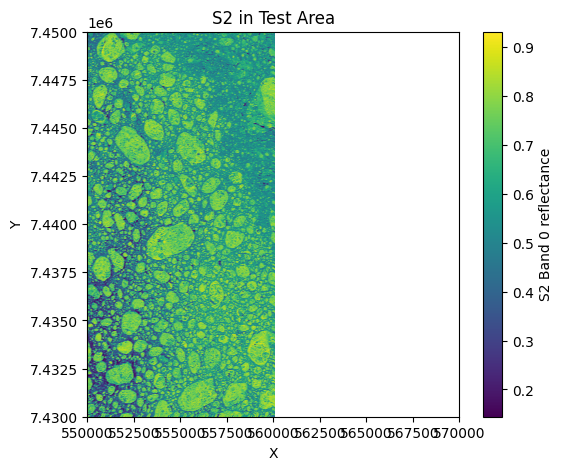

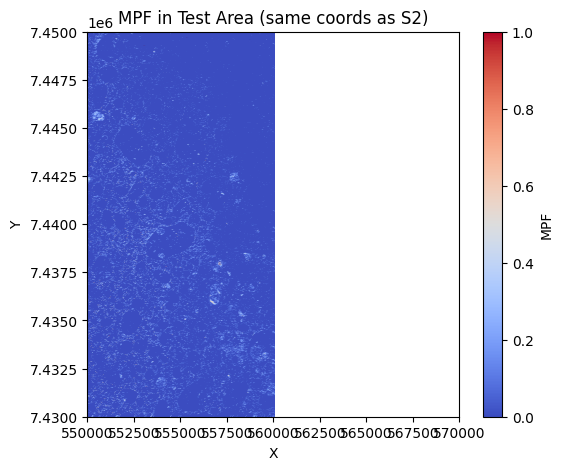

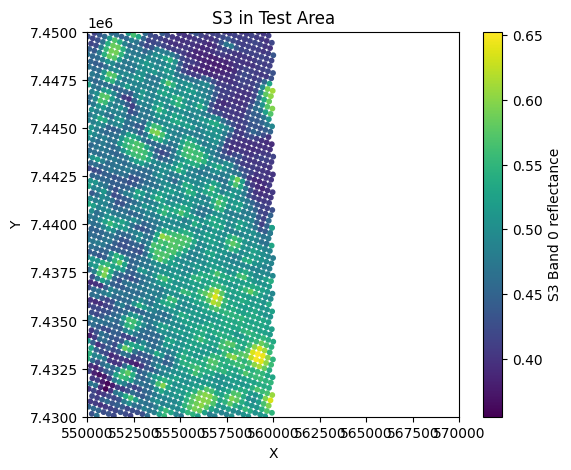

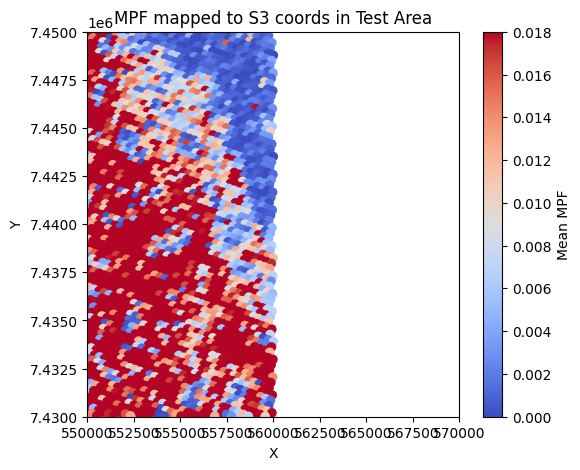

Test data extraction complete.


In [32]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from collections import defaultdict

# 1) Load zoomed S2, S3, MPF data
save_path = '/content/drive/MyDrive/GEOL0069/2324/Week 6 2025'
s2_data = np.load(save_path + '/s2_zoomed_data.npz')
s3_data = np.load(save_path + '/s3_zoomed_data.npz')
mpf_data = np.load(save_path + '/mpf_zoomed_data.npz')

# 2) Extract arrays
s2_x_all, s2_y_all = s2_data['x'], s2_data['y']
band_s2_all = s2_data['band_data']
mpf_all = mpf_data['mpf']
s3_x_all, s3_y_all = s3_data['x'], s3_data['y']
band_s3_all = s3_data['reflectance']

# 3) Define a test sub-subarea (different from training area)
test_x_min, test_x_max = 550000.0, 570000.0
test_y_min, test_y_max = 7430000.0, 7450000.0

# Filter S2 & MPF
cond_s2_test = (
    (s2_x_all >= test_x_min) & (s2_x_all <= test_x_max) &
    (s2_y_all >= test_y_min) & (s2_y_all <= test_y_max)
)
s2_x = s2_x_all[cond_s2_test]
s2_y = s2_y_all[cond_s2_test]
band_s2 = band_s2_all[cond_s2_test]
mpf_vals = mpf_all[cond_s2_test]

#  Filter S3
cond_s3_test = (
    (s3_x_all >= test_x_min) & (s3_x_all <= test_x_max) &
    (s3_y_all >= test_y_min) & (s3_y_all <= test_y_max)
)
s3_x = s3_x_all[cond_s3_test]
s3_y = s3_y_all[cond_s3_test]
band_s3 = band_s3_all[cond_s3_test]

print(f"S2 points in test area: {len(s2_x)}")
print(f"S3 points in test area: {len(s3_x)}")

# 4) PLOT S2, MPF, and S3 in test area
plt.figure(figsize=(6,5))
plt.scatter(s2_x, s2_y, c=band_s2[:, 0]/10000.0, cmap='viridis', s=1)
plt.colorbar(label='S2 Band 0 reflectance')
plt.title('S2 in Test Area')
plt.xlabel('X'); plt.ylabel('Y')
plt.xlim(test_x_min, test_x_max)
plt.ylim(test_y_min, test_y_max)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(s2_x, s2_y, c=mpf_vals, cmap='coolwarm', s=1)
plt.colorbar(label='MPF')
plt.title('MPF in Test Area (same coords as S2)')
plt.xlabel('X'); plt.ylabel('Y')
plt.xlim(test_x_min, test_x_max)
plt.ylim(test_y_min, test_y_max)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(s3_x, s3_y, c=band_s3[:, 0], cmap='viridis', s=10)
plt.colorbar(label='S3 Band 0 reflectance')
plt.title('S3 in Test Area')
plt.xlabel('X'); plt.ylabel('Y')
plt.xlim(test_x_min, test_x_max)
plt.ylim(test_y_min, test_y_max)
plt.show()

# 5) Use KDTree to associate S2 -> S3
s2_points = np.vstack((s2_x, s2_y)).T
s3_points = np.vstack((s3_x, s3_y)).T
tree = KDTree(s3_points)

distances, s3_idx_for_s2 = tree.query(s2_points)

# 6) Group S2 indices by S3 index
grouped = defaultdict(list)
for s2_idx, s3_idx in enumerate(s3_idx_for_s2):
    grouped[s3_idx].append(s2_idx)

# 7) Compute mean MPF for each S3 pixel
mpf_avg = np.full(len(s3_points), np.nan)
for s3_i, s2_list in grouped.items():
    mpf_for_this_s3 = mpf_vals[s2_list]
    if np.any(~np.isnan(mpf_for_this_s3)):
        mpf_avg[s3_i] = np.nanmean(mpf_for_this_s3)

# 8) Remove NaNs
valid_s3 = ~np.isnan(mpf_avg)
s3_x_clean = s3_x[valid_s3]
s3_y_clean = s3_y[valid_s3]
band_s3_clean = band_s3[valid_s3]
mpf_clean = mpf_avg[valid_s3]

# 9) Plot the S3-located MPF distribution
plt.figure(figsize=(6,5))
plt.scatter(s3_x_clean, s3_y_clean, c=mpf_clean, cmap='coolwarm', s=35,vmin=0,vmax=0.018)
plt.colorbar(label='Mean MPF')
plt.title('MPF mapped to S3 coords in Test Area')
plt.xlabel('X'); plt.ylabel('Y')
plt.xlim(test_x_min, test_x_max)
plt.ylim(test_y_min, test_y_max)
plt.show()

# 10) Save dataset
test_data = {
    "s3_x": s3_x_clean,
    "s3_y": s3_y_clean,
    "s3_features": band_s3_clean,
    "mpf_target": mpf_clean
}
np.savez(save_path + '/test_data.npz', **test_data)
print("Test data extraction complete.")

In [11]:
# Cell 1: Load Training and Test Data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load aligned training data
train_align = np.load('/content/drive/MyDrive/GEOL0069/2324/Week 6 2025/training_data_subsubarea_aligned.npz')
X_train_align_raw = train_align['s3_features']
y_train_align = train_align['mpf_target']

# Load misaligned training data
train_noalign = np.load('/content/drive/MyDrive/GEOL0069/2324/Week 6 2025/training_data_subsubarea_noalign.npz')
X_train_noalign_raw = train_noalign['s3_features']
y_train_noalign = train_noalign['mpf_target']

# Load test data
test_data = np.load('/content/drive/MyDrive/GEOL0069/2324/Week 6 2025/test_data.npz')
X_test_raw = test_data['s3_features']
y_test = test_data['mpf_target']
test_x = test_data['s3_x']
test_y = test_data['s3_y']

# Normalise data
scaler_align = StandardScaler()
X_train_align = scaler_align.fit_transform(X_train_align_raw)
X_test_align = scaler_align.transform(X_test_raw)

scaler_noalign = StandardScaler()
X_train_noalign = scaler_noalign.fit_transform(X_train_noalign_raw)
X_test_noalign = scaler_noalign.transform(X_test_raw)

print(f"Aligned data: {X_train_align.shape[0]} training samples, {X_test_align.shape[0]} test samples")
print(f"Misaligned data: {X_train_noalign.shape[0]} training samples, {X_test_noalign.shape[0]} test samples")

Aligned data: 4733 training samples, 2386 test samples
Misaligned data: 4725 training samples, 2386 test samples


## Polynomial Regression Models

Polynomial Regression (Degree 2) Results:
Aligned Model: MSE = 0.0001, R² = 0.4985
Misaligned Model: MSE = 0.0002, R² = 0.1431


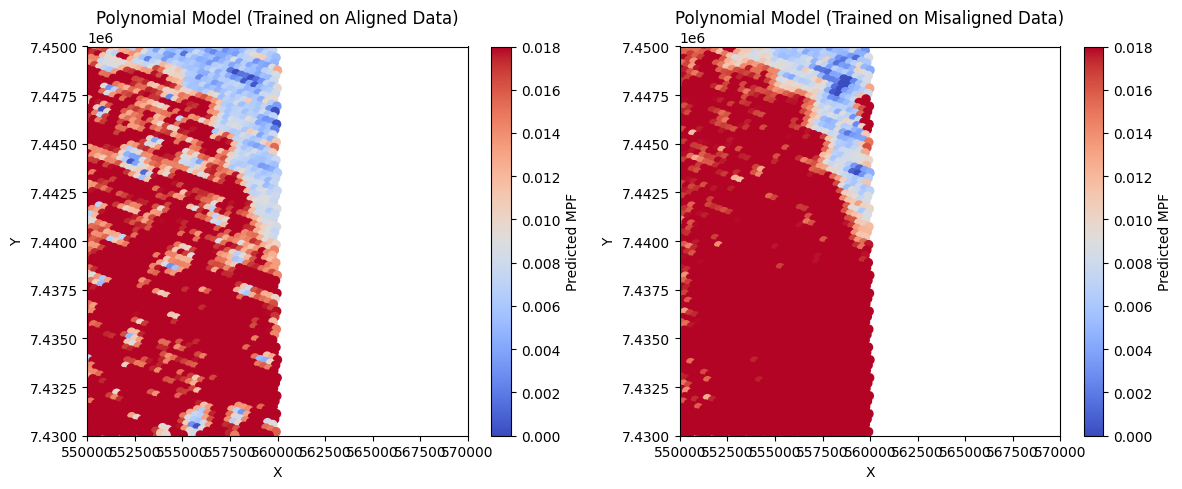

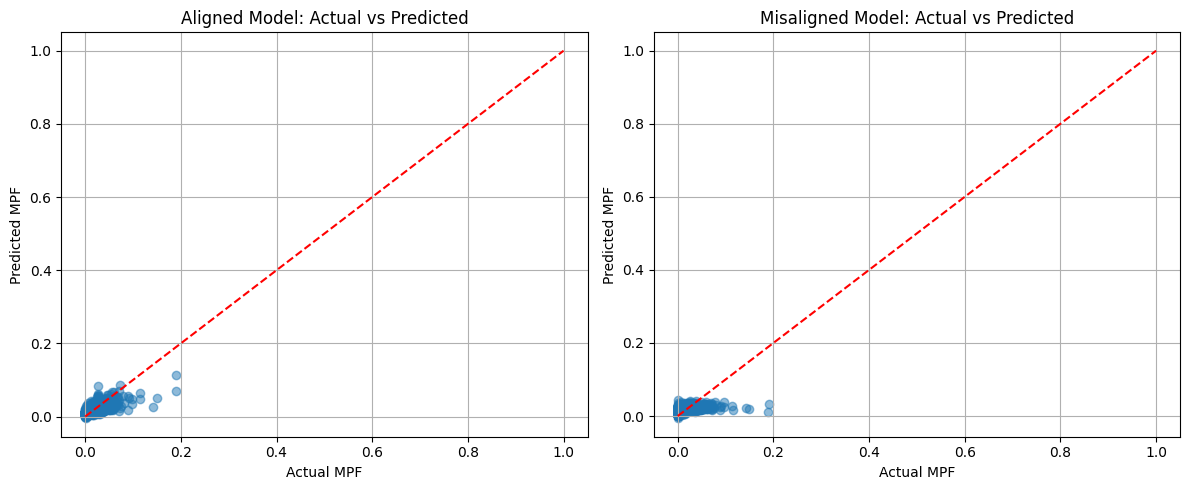

In [18]:
# Cell 2: Polynomial Regression Models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Polynomial features
poly = PolynomialFeatures(degree=2)

# Aligned data model
X_poly_train_align = poly.fit_transform(X_train_align)
model_poly_align = LinearRegression()
model_poly_align.fit(X_poly_train_align, y_train_align)

# Misaligned data model
X_poly_train_noalign = poly.fit_transform(X_train_noalign)
model_poly_noalign = LinearRegression()
model_poly_noalign.fit(X_poly_train_noalign, y_train_noalign)

# Test predictions
X_poly_test_align = poly.transform(X_test_align)
y_pred_poly_align = model_poly_align.predict(X_poly_test_align)

X_poly_test_noalign = poly.transform(X_test_noalign)
y_pred_poly_noalign = model_poly_noalign.predict(X_poly_test_noalign)

# Calculate metrics
mse_align = mean_squared_error(y_test, y_pred_poly_align)
r2_align = r2_score(y_test, y_pred_poly_align)

mse_noalign = mean_squared_error(y_test, y_pred_poly_noalign)
r2_noalign = r2_score(y_test, y_pred_poly_noalign)

print("Polynomial Regression (Degree 2) Results:")
print(f"Aligned Model: MSE = {mse_align:.4f}, R² = {r2_align:.4f}")
print(f"Misaligned Model: MSE = {mse_noalign:.4f}, R² = {r2_noalign:.4f}")

# Plot predicted MPF maps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sc1 = plt.scatter(test_x, test_y, c=y_pred_poly_align, cmap='coolwarm', s=35,vmin=0,vmax=0.018)
plt.colorbar(sc1, label='Predicted MPF')
plt.title('Polynomial Model (Trained on Aligned Data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(550000, 570000)
plt.ylim(7430000, 7450000)

plt.subplot(1, 2, 2)
sc2 = plt.scatter(test_x, test_y, c=y_pred_poly_noalign, cmap='coolwarm', s=35,vmin=0,vmax=0.018)
plt.colorbar(sc2, label='Predicted MPF')
plt.title('Polynomial Model (Trained on Misaligned Data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(550000, 570000)
plt.ylim(7430000, 7450000)

plt.tight_layout()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_poly_align, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual MPF')
plt.ylabel('Predicted MPF')
plt.title('Aligned Model: Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly_noalign, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual MPF')
plt.ylabel('Predicted MPF')
plt.title('Misaligned Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

## Neural Network Regression Model

 /usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network Results:
Aligned Model: MSE = 0.0004, R² = -0.5509
Misaligned Model: MSE = 0.0004, R² = -0.4126


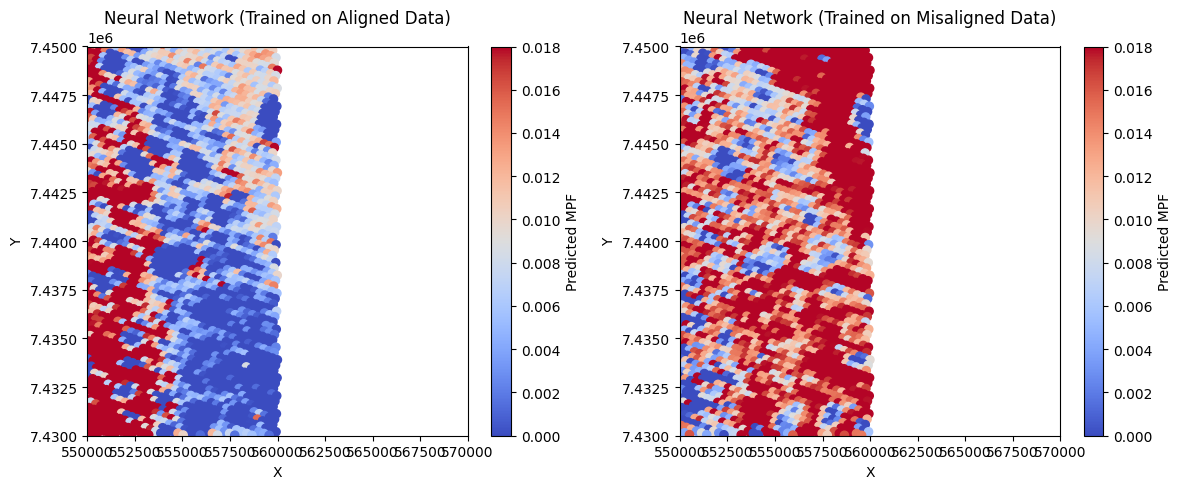

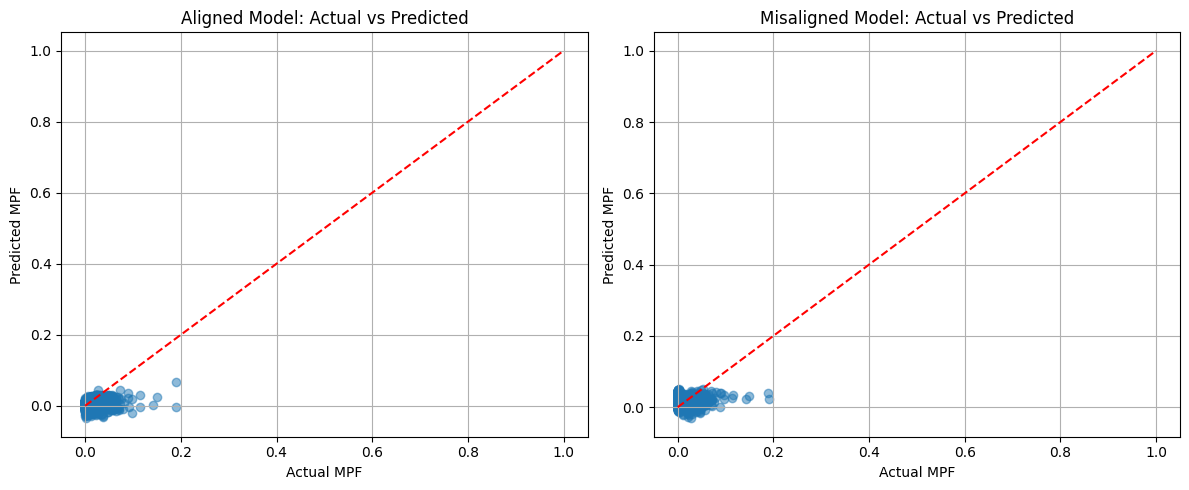

In [25]:
# Cell 3: Neural Network Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# For reproducibility
tf.random.set_seed(42)

# Function to create model with same architecture
def create_nn_model(input_dim):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train model on aligned data
model_nn_align = create_nn_model(X_train_align.shape[1])
model_nn_align.fit(
    X_train_align, y_train_align,
    epochs=10,
    batch_size=32,
    verbose=0
)

# Train model on misaligned data
model_nn_noalign = create_nn_model(X_train_noalign.shape[1])
model_nn_noalign.fit(
    X_train_noalign, y_train_noalign,
    epochs=10,
    batch_size=32,
    verbose=0
)

# Test predictions
y_pred_nn_align = model_nn_align.predict(X_test_align).flatten()
y_pred_nn_noalign = model_nn_noalign.predict(X_test_noalign).flatten()

# Calculate metrics
mse_align = mean_squared_error(y_test, y_pred_nn_align)
r2_align = r2_score(y_test, y_pred_nn_align)

mse_noalign = mean_squared_error(y_test, y_pred_nn_noalign)
r2_noalign = r2_score(y_test, y_pred_nn_noalign)

print("Neural Network Results:")
print(f"Aligned Model: MSE = {mse_align:.4f}, R² = {r2_align:.4f}")
print(f"Misaligned Model: MSE = {mse_noalign:.4f}, R² = {r2_noalign:.4f}")

# Plot predicted MPF maps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sc1 = plt.scatter(test_x, test_y, c=y_pred_nn_align, cmap='coolwarm', s=35,vmin=0,vmax=0.018)
plt.colorbar(sc1, label='Predicted MPF')
plt.title('Neural Network (Trained on Aligned Data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(550000, 570000)
plt.ylim(7430000, 7450000)

plt.subplot(1, 2, 2)
sc2 = plt.scatter(test_x, test_y, c=y_pred_nn_noalign, cmap='coolwarm', s=35,vmin=0,vmax=0.018)
plt.colorbar(sc2, label='Predicted MPF')
plt.title('Neural Network (Trained on Misaligned Data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(550000, 570000)
plt.ylim(7430000, 7450000)

plt.tight_layout()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_nn_align, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual MPF')
plt.ylabel('Predicted MPF')
plt.title('Aligned Model: Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_nn_noalign, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual MPF')
plt.ylabel('Predicted MPF')
plt.title('Misaligned Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# Gaussian Processes Regression Model

In [21]:
!pip install Gpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


Gaussian Process Regression Results:
Aligned Model: MSE = 0.0002, R² = 0.4006
Misaligned Model: MSE = 0.0003, R² = -0.0004


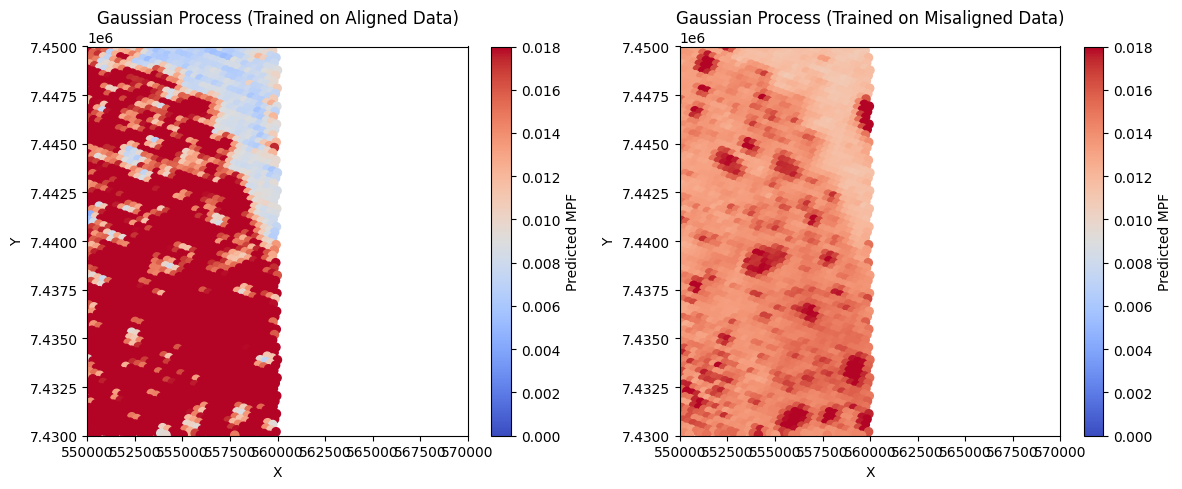

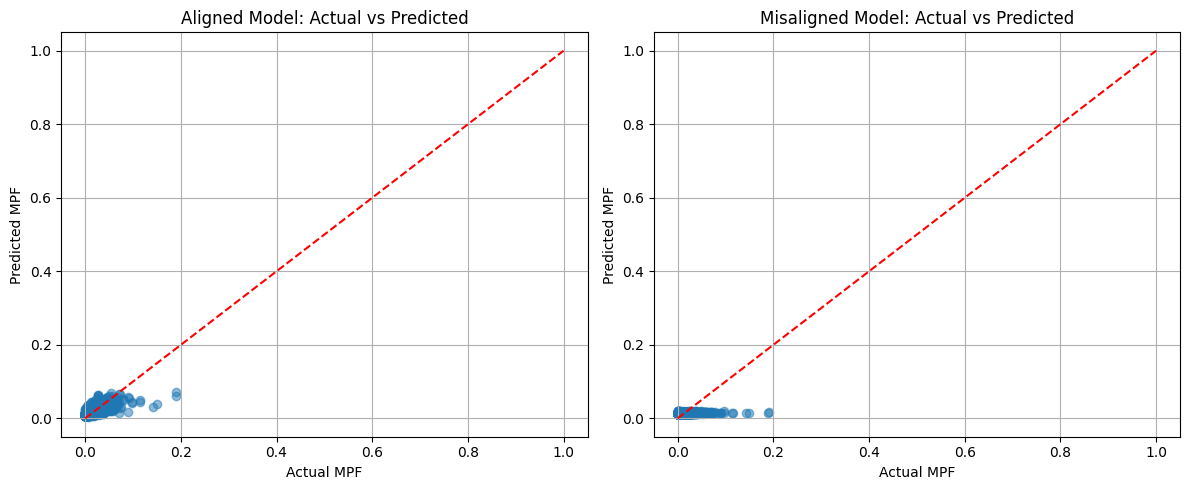

In [23]:
# Cell 4: Gaussian Process Regression Models
import GPy
import numpy as np

# For computational efficiency with GPR, subsample if datasets are large
max_train_samples = 1000

if X_train_align.shape[0] > max_train_samples:
    idx_align = np.random.choice(X_train_align.shape[0], max_train_samples, replace=False)
    X_train_align_sub = X_train_align[idx_align]
    y_train_align_sub = y_train_align[idx_align]
else:
    X_train_align_sub = X_train_align
    y_train_align_sub = y_train_align

if X_train_noalign.shape[0] > max_train_samples:
    idx_noalign = np.random.choice(X_train_noalign.shape[0], max_train_samples, replace=False)
    X_train_noalign_sub = X_train_noalign[idx_noalign]
    y_train_noalign_sub = y_train_noalign[idx_noalign]
else:
    X_train_noalign_sub = X_train_noalign
    y_train_noalign_sub = y_train_noalign

# Aligned model
kernel_align = GPy.kern.RBF(input_dim=X_train_align_sub.shape[1])
num_inducing = min(100, X_train_align_sub.shape[0] // 2)
gp_align = GPy.models.SparseGPRegression(
    X_train_align_sub,
    y_train_align_sub.reshape(-1, 1),
    kernel_align,
    num_inducing=num_inducing
)
gp_align.optimize(messages=False)

# Misaligned model
kernel_noalign = GPy.kern.RBF(input_dim=X_train_noalign_sub.shape[1])
num_inducing = min(100, X_train_noalign_sub.shape[0] // 2)
gp_noalign = GPy.models.SparseGPRegression(
    X_train_noalign_sub,
    y_train_noalign_sub.reshape(-1, 1),
    kernel_noalign,
    num_inducing=num_inducing
)
gp_noalign.optimize(messages=False)

# Test predictions
y_pred_gp_align, _ = gp_align.predict(X_test_align)
y_pred_gp_align = y_pred_gp_align.flatten()

y_pred_gp_noalign, _ = gp_noalign.predict(X_test_noalign)
y_pred_gp_noalign = y_pred_gp_noalign.flatten()

# Calculate metrics
mse_align = mean_squared_error(y_test, y_pred_gp_align)
r2_align = r2_score(y_test, y_pred_gp_align)

mse_noalign = mean_squared_error(y_test, y_pred_gp_noalign)
r2_noalign = r2_score(y_test, y_pred_gp_noalign)

print("Gaussian Process Regression Results:")
print(f"Aligned Model: MSE = {mse_align:.4f}, R² = {r2_align:.4f}")
print(f"Misaligned Model: MSE = {mse_noalign:.4f}, R² = {r2_noalign:.4f}")

# Plot predicted MPF maps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sc1 = plt.scatter(test_x, test_y, c=y_pred_gp_align, cmap='coolwarm', s=35, vmin=0, vmax=0.018)
plt.colorbar(sc1, label='Predicted MPF')
plt.title('Gaussian Process (Trained on Aligned Data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(550000, 570000)
plt.ylim(7430000, 7450000)

plt.subplot(1, 2, 2)
sc2 = plt.scatter(test_x, test_y, c=y_pred_gp_noalign, cmap='coolwarm', s=35, vmin=0, vmax=0.018)
plt.colorbar(sc2, label='Predicted MPF')
plt.title('Gaussian Process (Trained on Misaligned Data)')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(550000, 570000)
plt.ylim(7430000, 7450000)

plt.tight_layout()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gp_align, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual MPF')
plt.ylabel('Predicted MPF')
plt.title('Aligned Model: Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gp_noalign, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual MPF')
plt.ylabel('Predicted MPF')
plt.title('Misaligned Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

Model Performance Summary:
                                       MSE        R²
Polynomial Regression Aligned     0.000128   0.49848
                      Misaligned  0.000219  0.143142
Neural Network        Aligned     0.000242  0.049608
                      Misaligned  0.000357 -0.401585
Gaussian Process      Aligned     0.000153  0.400597
                      Misaligned  0.000255 -0.000429

Improvement from Alignment:
                      MSE Improvement % R² Improvement %
Polynomial Regression         41.469892       248.241605
Neural Network                32.191573       112.352961
Gaussian Process              40.085398     93569.062716


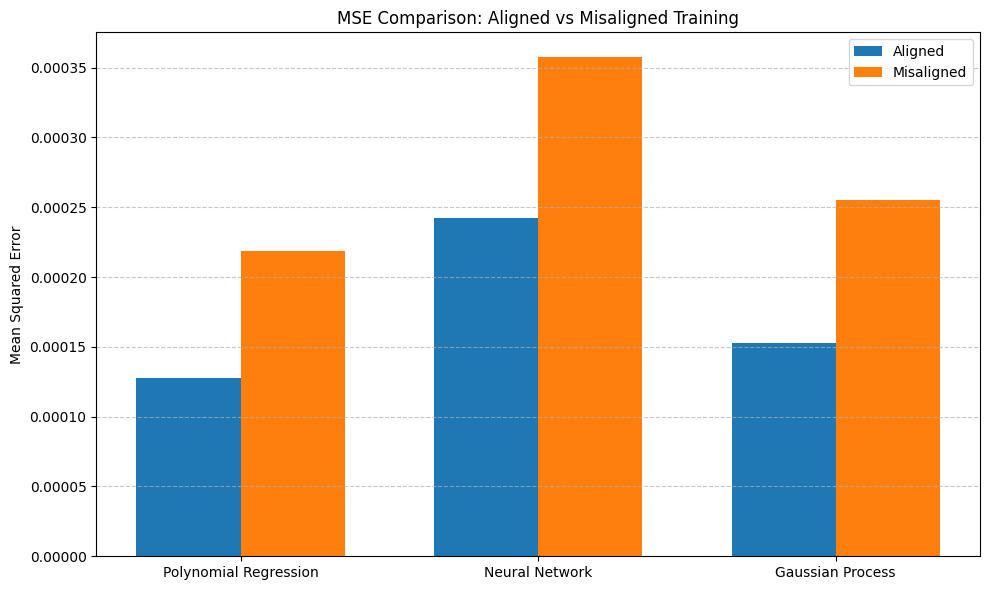

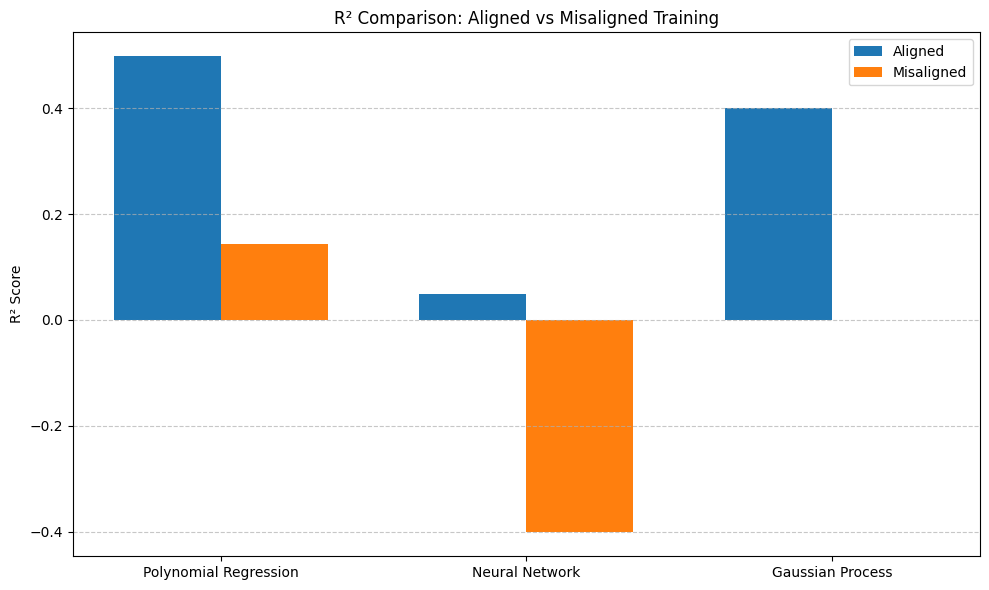

In [24]:
# Cell 5: Summary and Comparison of All Models
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create summary dataframe
models = ['Polynomial Regression', 'Neural Network', 'Gaussian Process']
metrics = ['MSE', 'R²']

try:
    results = pd.DataFrame(index=pd.MultiIndex.from_product([models, ['Aligned', 'Misaligned']]),
                          columns=metrics)

    # Polynomial regression results
    results.loc[('Polynomial Regression', 'Aligned'), 'MSE'] = mse_align_poly = mean_squared_error(y_test, y_pred_poly_align)
    results.loc[('Polynomial Regression', 'Aligned'), 'R²'] = r2_score(y_test, y_pred_poly_align)
    results.loc[('Polynomial Regression', 'Misaligned'), 'MSE'] = mse_noalign_poly = mean_squared_error(y_test, y_pred_poly_noalign)
    results.loc[('Polynomial Regression', 'Misaligned'), 'R²'] = r2_score(y_test, y_pred_poly_noalign)

    # Neural network results
    results.loc[('Neural Network', 'Aligned'), 'MSE'] = mse_align_nn = mean_squared_error(y_test, y_pred_nn_align)
    results.loc[('Neural Network', 'Aligned'), 'R²'] = r2_score(y_test, y_pred_nn_align)
    results.loc[('Neural Network', 'Misaligned'), 'MSE'] = mse_noalign_nn = mean_squared_error(y_test, y_pred_nn_noalign)
    results.loc[('Neural Network', 'Misaligned'), 'R²'] = r2_score(y_test, y_pred_nn_noalign)

    # Gaussian process results
    results.loc[('Gaussian Process', 'Aligned'), 'MSE'] = mse_align_gp = mean_squared_error(y_test, y_pred_gp_align)
    results.loc[('Gaussian Process', 'Aligned'), 'R²'] = r2_score(y_test, y_pred_gp_align)
    results.loc[('Gaussian Process', 'Misaligned'), 'MSE'] = mse_noalign_gp = mean_squared_error(y_test, y_pred_gp_noalign)
    results.loc[('Gaussian Process', 'Misaligned'), 'R²'] = r2_score(y_test, y_pred_gp_noalign)

    print("Model Performance Summary:")
    print(results)

    # Calculate improvement from alignment
    improvement = pd.DataFrame(index=models, columns=['MSE Improvement %', 'R² Improvement %'])

    improvement.loc['Polynomial Regression', 'MSE Improvement %'] = 100 * (mse_noalign_poly - mse_align_poly) / mse_noalign_poly
    improvement.loc['Neural Network', 'MSE Improvement %'] = 100 * (mse_noalign_nn - mse_align_nn) / mse_noalign_nn
    improvement.loc['Gaussian Process', 'MSE Improvement %'] = 100 * (mse_noalign_gp - mse_align_gp) / mse_noalign_gp

    improvement.loc['Polynomial Regression', 'R² Improvement %'] = 100 * (results.loc[('Polynomial Regression', 'Aligned'), 'R²'] -
                                                                 results.loc[('Polynomial Regression', 'Misaligned'), 'R²']) / abs(results.loc[('Polynomial Regression', 'Misaligned'), 'R²'])
    improvement.loc['Neural Network', 'R² Improvement %'] = 100 * (results.loc[('Neural Network', 'Aligned'), 'R²'] -
                                                        results.loc[('Neural Network', 'Misaligned'), 'R²']) / abs(results.loc[('Neural Network', 'Misaligned'), 'R²'])
    improvement.loc['Gaussian Process', 'R² Improvement %'] = 100 * (results.loc[('Gaussian Process', 'Aligned'), 'R²'] -
                                                           results.loc[('Gaussian Process', 'Misaligned'), 'R²']) / abs(results.loc[('Gaussian Process', 'Misaligned'), 'R²'])

    print("\nImprovement from Alignment:")
    print(improvement)

    # Barplot of MSE for all models
    plt.figure(figsize=(10, 6))
    x = np.arange(len(models))
    width = 0.35

    aligned_mse = [results.loc[(model, 'Aligned'), 'MSE'] for model in models]
    misaligned_mse = [results.loc[(model, 'Misaligned'), 'MSE'] for model in models]

    plt.bar(x - width/2, aligned_mse, width, label='Aligned')
    plt.bar(x + width/2, misaligned_mse, width, label='Misaligned')

    plt.ylabel('Mean Squared Error')
    plt.title('MSE Comparison: Aligned vs Misaligned Training')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Barplot of R² for all models
    plt.figure(figsize=(10, 6))

    aligned_r2 = [results.loc[(model, 'Aligned'), 'R²'] for model in models]
    misaligned_r2 = [results.loc[(model, 'Misaligned'), 'R²'] for model in models]

    plt.bar(x - width/2, aligned_r2, width, label='Aligned')
    plt.bar(x + width/2, misaligned_r2, width, label='Misaligned')

    plt.ylabel('R² Score')
    plt.title('R² Comparison: Aligned vs Misaligned Training')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except NameError:
    print("Error: Run all model cells first to calculate metrics for each model")